**GNN Recommender avec PyTorch Geometric + MovieLens (u.data + u.item)**

**1)- installation des librairies**

In [ ]:
# Install PyTorch Geometric + CPU version
!pip install torch torchvision torchaudio -q
!pip install torch-geometric -q

In [2]:
import torch, torch_geometric
print("PyTorch:", torch.__version__)
print("PyG:", torch_geometric.__version__)

PyTorch: 2.9.0+cpu
PyG: 2.7.0


**2)- importation du dataset (u.data + u.tem)**

In [4]:
import pandas as pd

# Load interactions (user, item, rating, timestamp)
data = pd.read_csv("u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])

# Load movie info
movies = pd.read_csv("u.item", sep="|", encoding="ISO-8859-1", header=None,
                     names=["movie_id","title","release","unknown"]+[f"genre{i}" for i in range(20)])

# Define num_users and num_items here
num_users = data['user_id'].nunique()
num_items = data['item_id'].nunique()

print("Interactions:", data.shape)
print("Movies:", movies.shape)
print("Users:", num_users, "Movies:", num_items)
data.head()

Interactions: (100000, 4)
Movies: (1682, 24)
Users: 943 Movies: 1682


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
import torch
from torch_geometric.data import Data
# Re-index user & item IDs from 0
data['user_id'] -= 1
data['item_id'] -= 1

num_users = data['user_id'].max() + 1
num_items = data['item_id'].max() + 1

# Décalage pour que les films aient des IDs différents des users
movie_offset = num_users
data['item_id'] = data['item_id'] + movie_offset

# Create edge index (2 x num_edges)
edge_index = torch.tensor([data['user_id'].values, data['item_id'].values], dtype=torch.long)

# Graph Data
graph = Data(edge_index=edge_index)
graph.num_nodes = num_users + num_items

print("Nodes:", graph.num_nodes)
print("Edges:", graph.edge_index.shape)

Nodes: 2625
Edges: torch.Size([2, 100000])


/tmp/ipython-input-891720630.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  edge_index = torch.tensor([data['user_id'].values, data['item_id'].values], dtype=torch.long)


**Implémentation d’un Mini-LightGCN**

In [6]:
import torch.nn as nn

class MiniLightGCN(nn.Module):
    def __init__(self, num_nodes, embed_dim=32):
        super().__init__()
        self.embeddings = nn.Embedding(num_nodes, embed_dim)
        nn.init.xavier_uniform_(self.embeddings.weight)

    def forward(self, edge_index):
        src, dst = edge_index
        out = torch.zeros_like(self.embeddings.weight)
        out.index_add_(0, src, self.embeddings.weight[dst])
        out.index_add_(0, dst, self.embeddings.weight[src])
        return out / 2

model = MiniLightGCN(graph.num_nodes)
node_repr = model(graph.edge_index)
print(node_repr.shape)

torch.Size([2625, 32])


**Générer des recommandations Top-N (Filtrer les films déjà vus par l'utilisateur)**

In [7]:
USER_ID = 1

user_vec = node_repr[USER_ID]
movie_vecs = node_repr[movie_offset:]

scores = movie_vecs @ user_vec

watched = [i - movie_offset for i in data[data.user_id == USER_ID].item_id]
mask = torch.ones(num_items, dtype=torch.bool)
mask[watched] = False

unwatched = torch.arange(num_items)[mask]
top_idx = torch.topk(scores[mask], 10).indices
recommended_ids = unwatched[top_idx].tolist()

rec_movies = movies[movies.movie_id.isin([i+1 for i in recommended_ids])]
display(rec_movies[['movie_id', 'title', 'release']])

,movie_id,title,release
10,11,Seven (Se7en) (1995),01-Jan-1995
95,96,Terminator 2: Judgment Day (1991),01-Jan-1991
131,132,"Wizard of Oz, The (1939)",01-Jan-1939
133,134,Citizen Kane (1941),01-Jan-1941
143,144,Die Hard (1988),01-Jan-1988
173,174,Raiders of the Lost Ark (1981),01-Jan-1981
181,182,GoodFellas (1990),01-Jan-1990
203,204,Back to the Future (1985),01-Jan-1985
422,423,E.T. the Extra-Terrestrial (1982),01-Jan-1982
482,483,Casablanca (1942),01-Jan-1942


**Visualiser une partie du Graphe**

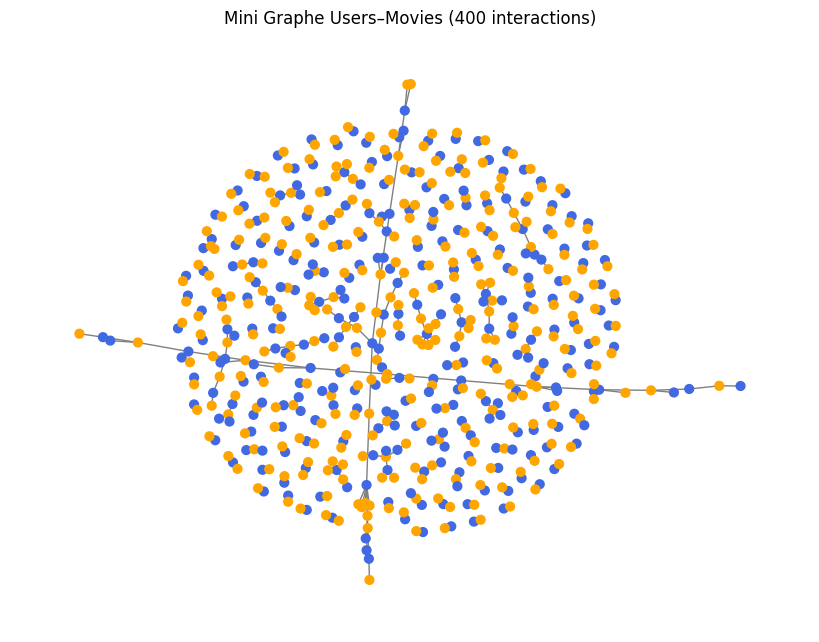

In [8]:
import networkx as nx #pour créer et manipuler des graphes
import matplotlib.pyplot as plt

G = nx.Graph()

sample = data.sample(400)

user_nodes = []
item_nodes = []

for _, row in sample.iterrows():
    u = f"U{row['user_id']}"
    #m = f"M{row['item_id']}"
    m = f"M{row['item_id']-movie_offset}"

    G.add_edge(u, m)

    user_nodes.append(u)
    item_nodes.append(m)

# Liste de couleurs dans l'ordre des nodes du graphe
node_color = []
for node in G.nodes():
    if node.startswith("U"):
        node_color.append("royalblue")   # couleur users
    else:
        node_color.append("orange")      # couleur items

plt.figure(figsize=(8,6))
nx.draw(
    G,
    node_size=40,
    font_size=6,
    node_color=node_color,
    edge_color="gray"
)
plt.title("Mini Graphe Users–Movies (400 interactions)")
plt.show()